# Brain tumor detection model

This notebook uses deep learning to classify MRI and X-ray images for early brain tumor and lung cancer detection. Developed with TensorFlow and Keras, it addresses diagnostic challenges in low-resource healthcare settings like Rwanda.

### Loading dependencies

In [68]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.regularizers import l1, l2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img

### Loading Data and data preprocessing

In [69]:
training_dir = "data/training"
validation_dir = "data/validation"

datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(64, 64),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training",
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    color_mode="grayscale", 
    class_mode="categorical",
)

Found 217 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [70]:
def plot_images_from_path(path, num_images=3):
    images = os.listdir(path)
    plt.figure(figsize=(20, 20))

    random_images = random.sample(images, min(num_images, len(images)))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(300, 300))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

#### visualise tumor images

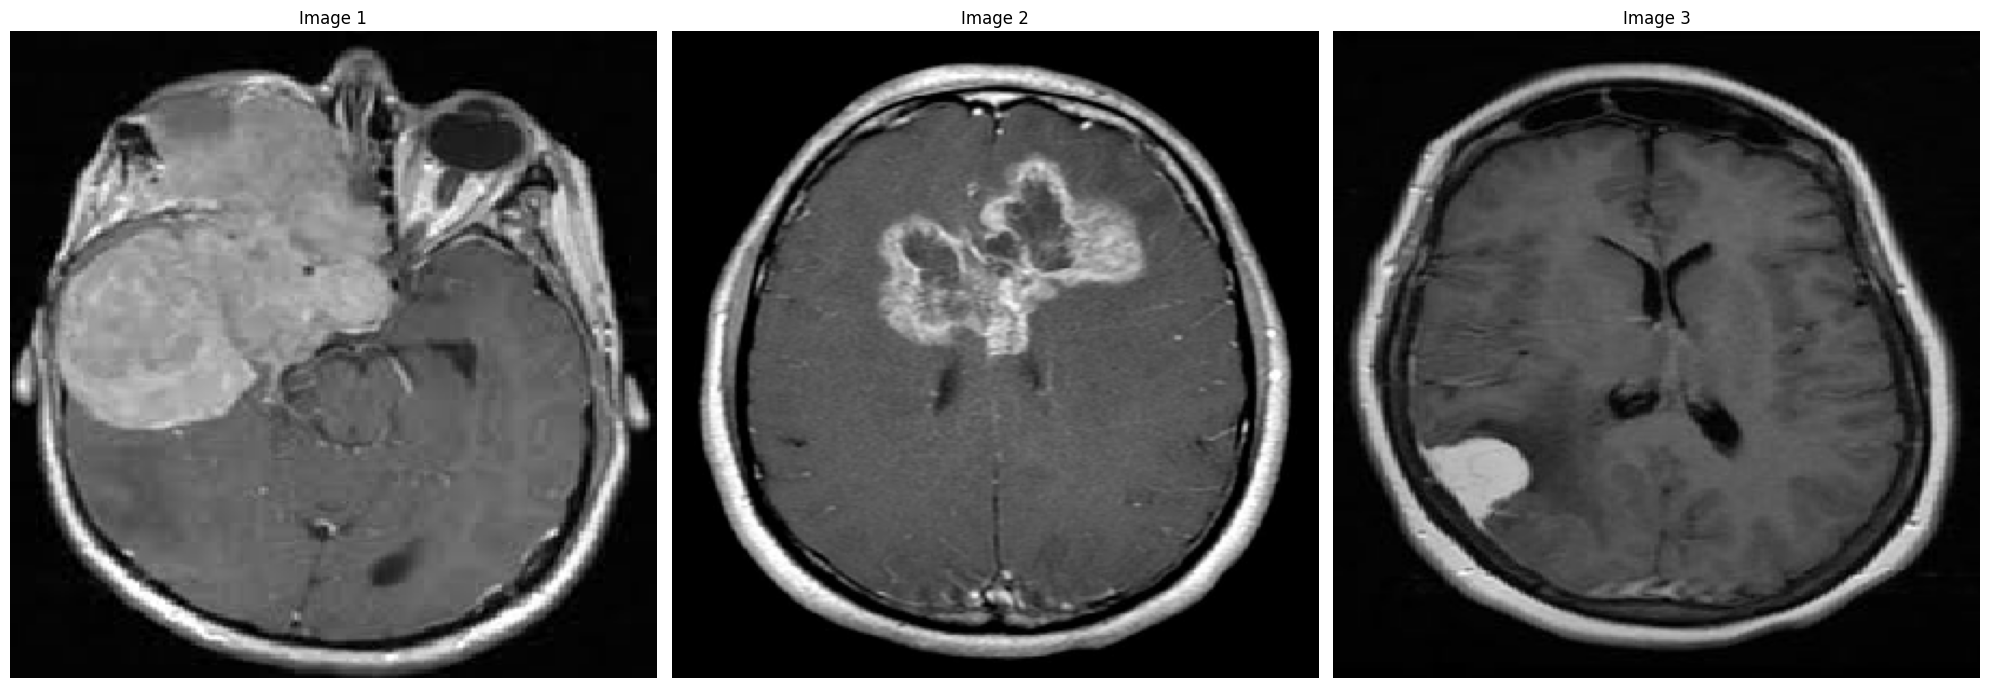

In [71]:
plot_images_from_path("data/training/yes")

#### visualise No Tumor Images

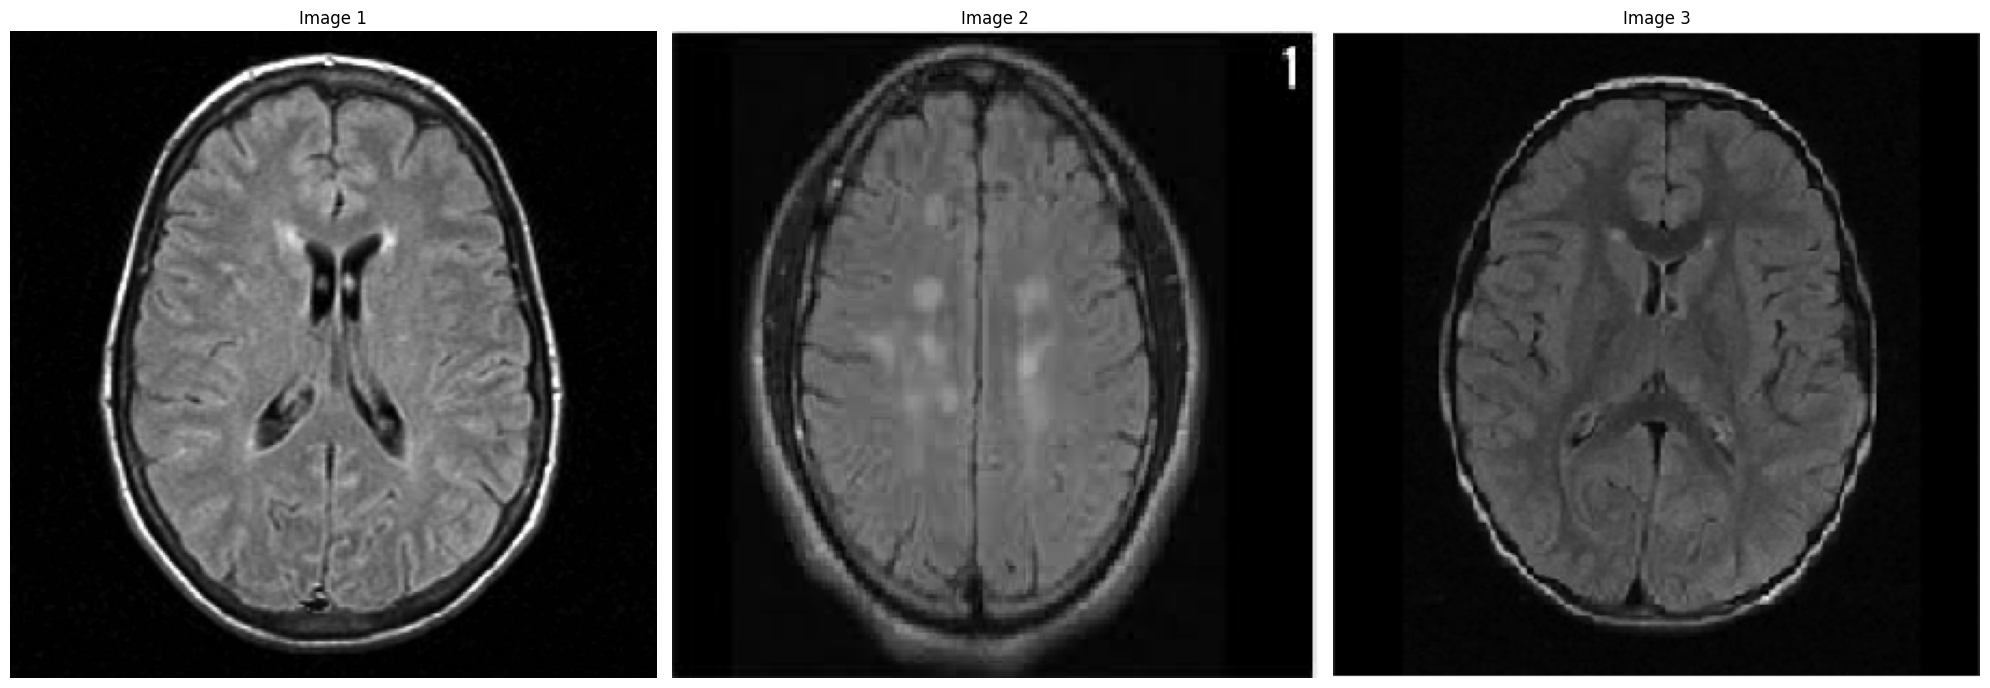

In [72]:
plot_images_from_path("data/training/no")

### Model1 Architecture

In [73]:
model1 = Sequential()

noOfFilter1 = 32
noOfFilter2 = 64
sizeOfFilter1 = (3, 3)
sizeOfFilter2 = (3, 3)
sizeOfPool = (2, 2)
noOfNodes = (16, 32, 64, 128)
input_shape = (64, 64, 1)


model1.add(Conv2D(noOfFilter1, sizeOfFilter1, activation="relu", input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=sizeOfPool))

model1.add(Conv2D(noOfFilter2, sizeOfFilter2, activation="relu"))
model1.add(MaxPooling2D(pool_size=sizeOfPool))

model1.add(Flatten())

model1.add(Dense(noOfNodes[2], activation="relu"))
model1.add(Dense(noOfNodes[1], activation="relu"))
model1.add(Dense(train_generator.num_classes, activation="softmax"))

model1.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=['accuracy', Precision(), Recall()])
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dense_24 (Dense)            (None, 64)               

#### plotting & Analysis function

In [74]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()
    return

def display_accuracy(history):
    model1_training_accuracy = history.history["accuracy"][-1] * 100 
    model1_validation_accuracy = history.history["val_accuracy"][-1] * 100

    print(f"Final Training Accuracy: {model1_training_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {model1_validation_accuracy:.2f}%")
    return

def display_confusion_matrix(trained_model):
    validation_generator.reset()
    predictions = trained_model.predict(validation_generator, verbose=1)

    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())
    conf_matrix = confusion_matrix(predicted_classes, true_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

#### train model1

In [75]:
model1_history = model1.fit(train_generator, epochs=20, batch_size=32, validation_data=validation_generator, verbose=1)
model1.save('saved_models/model1.keras')

Epoch 1/20


2024-10-13 13:41:01.235587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6129 - precision_8: 0.6129 - recall_8: 0.6129

2024-10-13 13:41:03.648381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 3s 231ms/step - loss: 0.6255 - accuracy: 0.6129 - precision_8: 0.6129 - recall_8: 0.6129 - val_loss: 0.5770 - val_accuracy: 0.7222 - val_precision_8: 0.7222 - val_recall_8: 0.7222
Epoch 2/20
7/7 [==============================] - 1s 137ms/step - loss: 0.5152 - accuracy: 0.7834 - precision_8: 0.7834 - recall_8: 0.7834 - val_loss: 0.5344 - val_accuracy: 0.6944 - val_precision_8: 0.6944 - val_recall_8: 0.6944
Epoch 3/20
7/7 [==============================] - 1s 142ms/step - loss: 0.4846 - accuracy: 0.8018 - precision_8: 0.8018 - recall_8: 0.8018 - val_loss: 0.4780 - val_accuracy: 0.8056 - val_precision_8: 0.8056 - val_recall_8: 0.8056
Epoch 4/20
7/7 [==============================] - 1s 139ms/step - loss: 0.4642 - accuracy: 0.7926 - precision_8: 0.7926 - recall_8: 0.7926 - val_loss: 0.5658 - val_accuracy: 0.7222 - val_precision_8: 0.7222 - val_recall_8: 0.7222
Epoch 5/20
7/7 [==============================] - 1s 135ms/step - loss: 0.4969 - accuracy: 

#### model1 Error analysis

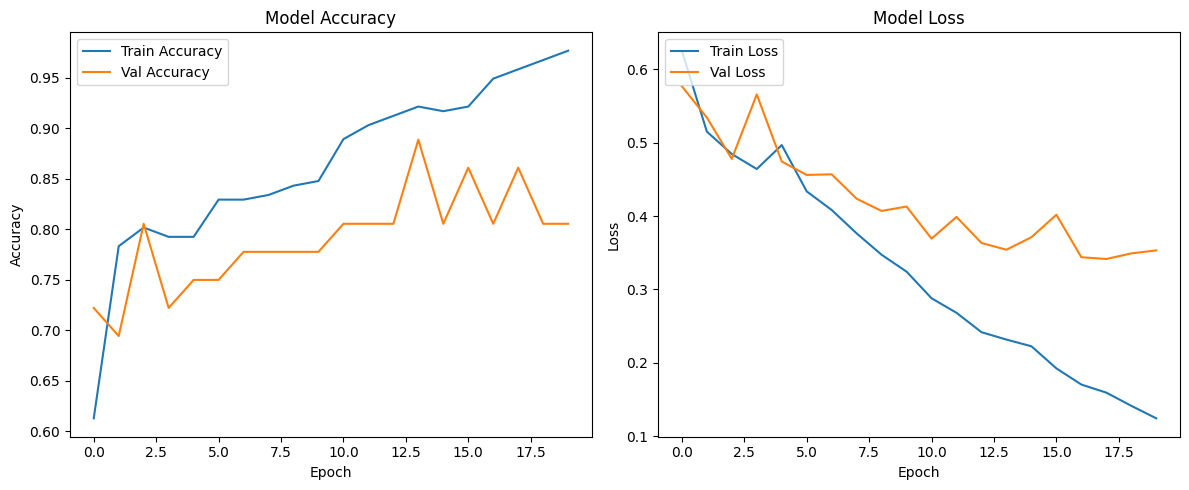

In [76]:
plot_history(model1_history)

In [77]:
display_accuracy(model1_history)

Final Training Accuracy: 97.70%
Final Validation Accuracy: 80.56%


2/2 [==============================] - 0s 5ms/step


2024-10-13 13:41:33.981883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


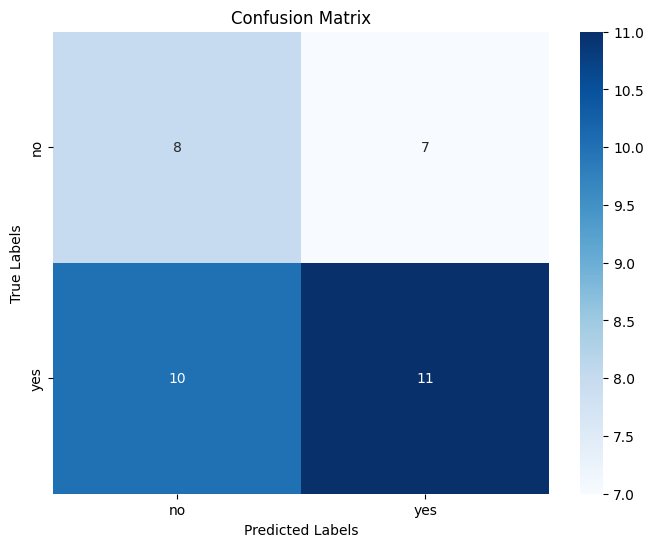

              precision    recall  f1-score   support

          no       0.53      0.44      0.48        18
         yes       0.52      0.61      0.56        18

    accuracy                           0.53        36
   macro avg       0.53      0.53      0.52        36
weighted avg       0.53      0.53      0.52        36



In [78]:
display_confusion_matrix(model1)

### Model2 Architecture

In [62]:
model2 = Sequential()

noOfFilter1 = 32
noOfFilter2 = 64
sizeOfFilter1 = (3, 3)
sizeOfFilter2 = (3, 3)
sizeOfPool = (2, 2)
noOfNodes = (16, 32, 64, 128)
input_shape = (64, 64, 1)


model2.add(Conv2D(noOfFilter1, sizeOfFilter1, activation="relu", input_shape=input_shape, kernel_regularizer=l2(l2=0.001)))
model2.add(MaxPooling2D(pool_size=sizeOfPool))
model2.add(Dropout(0.4))

model2.add(Conv2D(noOfFilter2, sizeOfFilter2, activation="relu", kernel_regularizer=l2(l2=0.001)))
model2.add(MaxPooling2D(pool_size=sizeOfPool))
model2.add(Dropout(0.4))

model2.add(Flatten())

model2.add(Dense(noOfNodes[2], activation="relu", kernel_regularizer=l2(l2=0.001)))
model2.add(Dropout(0.4))
model2.add(Dense(noOfNodes[1], activation="relu", kernel_regularizer=l2(l2=0.001)))
model2.add(Dense(train_generator.num_classes, activation="softmax"))

model2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)       

#### callbacks

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
check_point = ModelCheckpoint(filepath='callbacks/model_checkpoint.keras', save_best_only=True, mode='auto', verbose=1)

#### train model2

In [64]:
model2_history = model2.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop, check_point]
)
model2.save("saved_models/model2.keras")

Epoch 1/20


2024-10-13 13:36:54.303075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6452 - precision_7: 0.6452 - recall_7: 0.6452

2024-10-13 13:36:57.245560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.80153, saving model to callbacks/model_checkpoint.keras
7/7 [==============================] - 3s 200ms/step - loss: 0.8482 - accuracy: 0.6452 - precision_7: 0.6452 - recall_7: 0.6452 - val_loss: 0.8015 - val_accuracy: 0.5833 - val_precision_7: 0.5833 - val_recall_7: 0.5833
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.7719 - accuracy: 0.7327 - precision_7: 0.7327 - recall_7: 0.7327
Epoch 2: val_loss improved from 0.80153 to 0.76139, saving model to callbacks/model_checkpoint.keras
7/7 [==============================] - 1s 161ms/step - loss: 0.7719 - accuracy: 0.7327 - precision_7: 0.7327 - recall_7: 0.7327 - val_loss: 0.7614 - val_accuracy: 0.7500 - val_precision_7: 0.7500 - val_recall_7: 0.7500
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.7512 - precision_7: 0.7512 - recall_7: 0.7512
Epoch 3: val_loss improved from 0.76139 to 0.71378, saving model to callbacks/model_checkpoint.ke

#### model2 error analysis

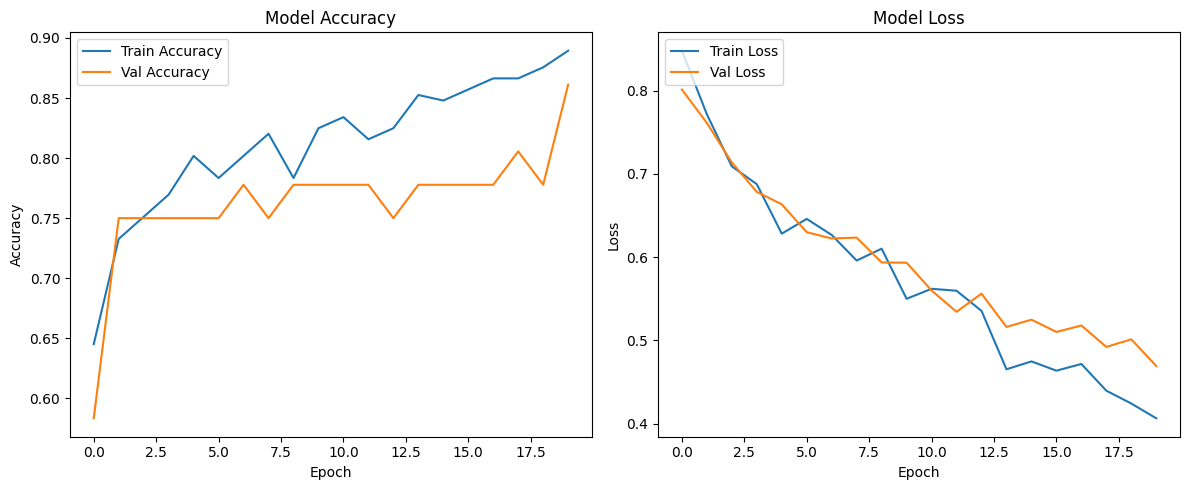

In [65]:
plot_history(model2_history)

In [66]:
display_accuracy(model2_history)

Final Training Accuracy: 88.94%
Final Validation Accuracy: 86.11%


1/2 [==============>...............] - ETA: 0s

2024-10-13 13:37:20.277965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 6ms/step


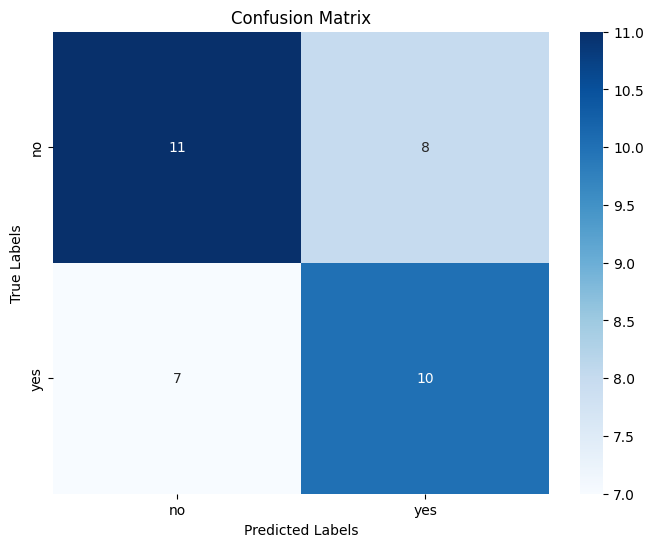

              precision    recall  f1-score   support

          no       0.58      0.61      0.59        18
         yes       0.59      0.56      0.57        18

    accuracy                           0.58        36
   macro avg       0.58      0.58      0.58        36
weighted avg       0.58      0.58      0.58        36



In [67]:
display_confusion_matrix(model2)